This notebook contains model testing for predicting house prices using linear regression. 

- Data preparation: 
  - Perform one-hot encoding where a 'standard reference category' feature value is dropped for interpretability
  - Scale features with MinMaxScaler or StandardScaler, for comparison
  - Check the variance inflation factor

- Description of models: 
  - Model 1: OLS 
  - Model 2: OLS with non-linearity in features accounted for 
  - Model 3: Linear model with Lasso regularization

- Model testing: 
  - Drop feature with maximum p-value until all p-values are <= 0.05
  - Compare performance of minmax versus standard scaling using LOOCV

- Model analysis and comparison: 
  - Compare LOOCV residuals for all models and error metrics
  - Perform outlier analysis
  - Perform feature importance analysis 

In [1]:
# Import my plotting preferences
import myplotprefs as mpp

# Import libraries
import itertools
import warnings
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as px
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score

In [2]:
# Set viewing preferences
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
mpl.rcParams["figure.max_open_warning"] = 50
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load cleaned data
data_clean = pd.read_csv("../data/data_clean.csv")
data = data_clean.copy()

# Define functions

In [4]:
# Check the variance inflation factor (VIF)
def check_vif(data):
    vif = pd.DataFrame()
    vif["feature"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i).round(0) for i in range (len(data.columns))]
    return vif

In [5]:
# Return LOOCV residual_list, residual_ratio_list, overall_r2
# exp=False exists for the case when nonlinear features are exponentiated and need to be transformed back to original scale
# lasso=False (OLS) is the default, lasso=True is for the lasso model with specified alpha (best_alpha_from_LassoCV)
def return_loocv(x_array, y_array, exp=False, lasso=False, alpha=0):
    residuals, residuals_ratio, coef_per_fold = [], [], []
    loo = LeaveOneOut()

    for train_index, test_index in loo.split(x_array):
        x_train, x_test = x_array[train_index], x_array[test_index]
        y_train, y_test = y_array[train_index], y_array[test_index]

        if lasso:
            model = Lasso(alpha=alpha)
            results = model.fit(x_train, y_train)
            coef_per_fold.append(results.coef_)

        else:
            model = sm.OLS(y_train, x_train)
            results = model.fit()
            coef_per_fold.append(results.params)

        y_pred = results.predict(x_test)
        
        if exp == True:
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            
        residual = y_pred - y_test 
        residual_ratio = residual / y_test
        
        residuals.append(residual[0])
        residuals_ratio.append(residual_ratio[0])  
        
    if exp == True:
        y_array = np.exp(y_array)
        
    overall_r2 = r2_score(y_array, y_array - residuals)
    
    return residuals, residuals_ratio, overall_r2, coef_per_fold

In [6]:
# Return model metrics
def return_metrics(residuals, residuals_ratio):
    mse = np.mean(np.square(residuals))
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))
    mpe = np.mean(residuals_ratio)*100
    mape = np.mean(np.abs(residuals_ratio))*100
    return mse, rmse, mae, mpe, mape

In [7]:
# Print model metrics
def print_metrics(residuals, residuals_ratio, r2):
    mse, rmse, mae, mpe, mape = return_metrics(residuals, residuals_ratio)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MPE:", mpe)
    print("MAPE:", mape)
    print("R2:", r2)

# Data Preparation

In [8]:
# Separate training and target
y = data["SalePrice"] / 1000 # Exress units in K e.g. 270K 
X_unscaled = data.drop("SalePrice", axis=1)

Encode categorical variables: Drop the value with the highest distribution as the "standard reference category" for interpretability. For example, the standard sale condition is "Normal", so we can see how any other sale type is associated with higher or lower sale price

In [9]:
# Get the categorical columns
categorical_columns = X_unscaled.select_dtypes(include=["object"]).columns

# Make a list of what will be the "standard reference category" for each feature
std_ref_cat = []

# Iterate through categorical columns and drop the column that represents the standard reference
for column in categorical_columns:    
    dummies = pd.get_dummies(X_unscaled[column], prefix=column)
    distribution = dummies.sum()
    column_to_drop = distribution.idxmax()
    std_ref_cat.append(column_to_drop)
    dummies.drop(column_to_drop, axis=1, inplace=True)
    X_unscaled = pd.concat([X_unscaled, dummies], axis=1)
    X_unscaled.drop(column, axis=1, inplace=True)

In [10]:
# Print the standard reference categories
std_ref_cat

['MSZoning_RL',
 'Street_Pave',
 'Alley_NoAlley',
 'LotShape_Reg',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'Neighborhood_NAmes',
 'BldgType_1Fam',
 'HouseStyle_1Story',
 'RoofStyle_Gable',
 'RoofMatl_CompShg',
 'Exterior1st_VinylSd',
 'Exterior2nd_VinylSd',
 'Foundation_PConc',
 'BsmtQual_TA',
 'BsmtCond_TA',
 'BsmtExposure_No',
 'BsmtFinType1_Unf',
 'BsmtFinType2_Unf',
 'Heating_GasA',
 'CentralAir_Y',
 'Electrical_SBrkr',
 'FireplaceQu_NoFireplace',
 'GarageType_Attchd',
 'GarageFinish_Unf',
 'GarageQual_TA',
 'GarageCond_TA',
 'PavedDrive_Y',
 'PoolQC_NoPool',
 'Fence_NoFence',
 'MiscFeature_NoMiscFeature',
 'SaleType_WD',
 'SaleCondition_Normal']

In [11]:
# Scale features (MinMaxScaler)
scaler_minmax = MinMaxScaler()
X0_minmax = scaler_minmax.fit_transform(X_unscaled)
X0_minmax = pd.DataFrame(X0_minmax, index=X_unscaled.index, columns=X_unscaled.columns)

In [12]:
# Scale features (StandardScaler)
scaler_std = StandardScaler()
X0_std = scaler_std.fit_transform(X_unscaled)
X0_std = pd.DataFrame(X0_std, index=X_unscaled.index, columns=X_unscaled.columns)

In [13]:
# Add constant term to feature matrix
X0_minmax = sm.add_constant(X0_minmax)
X0_std = sm.add_constant(X0_std)

Note: Do not consider VIF values for dummy variables

In [14]:
# Check variance inflation factor (minmax)
check_vif(X0_minmax)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,399.0
1,LotArea,3.0
2,OverallCond,2.0
3,ExterCond,2.0
4,BsmtFinSF1,14.0
5,BsmtFinSF2,5.0
6,BsmtUnfSF,11.0
7,HeatingQC,2.0
8,1stFlrSF,inf
9,2ndFlrSF,inf


In [15]:
# Check variance inflation factor (std)
check_vif(X0_std)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,1.0
1,LotArea,3.0
2,OverallCond,2.0
3,ExterCond,2.0
4,BsmtFinSF1,14.0
5,BsmtFinSF2,5.0
6,BsmtUnfSF,11.0
7,HeatingQC,2.0
8,1stFlrSF,inf
9,2ndFlrSF,inf


# Model 1: OLS

In [16]:
# OLS Model 1: Loop to drop feature with maximum p-value until all p-values are <= 0.05 (minmax)
X1_minmax = X0_minmax.copy()

exit_loop = False

while not exit_loop:
    ols_model = sm.OLS(y, X1_minmax).fit()
    p_values = ols_model.pvalues
    max_p_value_feature = p_values.idxmax()
    if p_values[max_p_value_feature] <= 0.05:
        exit_loop = True
    else:
        X1_minmax = X1_minmax.drop(max_p_value_feature, axis=1)

ols_1_minmax = sm.OLS(y, X1_minmax).fit()
ols_1_minmax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              1787.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):                        0.00
Time:                        09:02:50   Log-Likelihood:                         -6692.0
No. Observations:                1460   AIC:                                  1.349e+04
Df Residuals:                    1406   BIC:                                  1.378e+04
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                  85.7631     16.519      5.192      0.000      53.359     118.167
OverallCond              44.3846      5.332      8.324      0.000      33.925      54.844
BsmtFinSF1              196.8350     22.895      8.597      0.000     151.922     241.748
BsmtFinSF2               29.4291      8.506      3.460      0.001      12.743      46.116
BsmtUnfSF                41.5426      9.272      4.480      0.000      23.354      59.731
1stFlrSF                222.4964     17.543     12.683      0.000     188.083     256.910
2ndFlrSF                110.7069      4.177     26.506      0.000     102.514     118.900
KitchenAbvGr            -58.3502      9.531     -6.122      0.000     -77.047     -39.653
Functional               36.2607      4.469      8.113      0.000      27.493      45.028
Fireplaces               12.1004      3.698      3.272      0.001       4.845      19.355
GarageCars               36.5276      5.772      6.328      0.000      25.205      47.851
WoodDeckSF               12.5523      4.869      2.578      0.010       3.001      22.104
ScreenPorch              16.6435      5.857      2.842      0.005       5.155      28.132
PoolArea                168.8348     24.228      6.968      0.000     121.307     216.363
HomeAge                 -40.9265      4.922     -8.315      0.000     -50.582     -31.271
GenQual                 108.1890      7.098     15.242      0.000      94.265     122.113
HasProxArtery           -15.1932      3.777     -4.022      0.000     -22.603      -7.784
HasProxFeedr             -7.3902      2.804     -2.636      0.008     -12.890      -1.890
HasProxPosN             -27.4530      5.779     -4.750      0.000     -38.790     -16.116
HasProxRRAe             -20.5128      7.105     -2.887      0.004     -34.451      -6.574
MSZoning_C (all)        -19.6214      8.034     -2.442      0.015     -35.381      -3.861
LandContour_Bnk          -7.9911      3.340     -2.393      0.017     -14.542      -1.440
LandContour_Low         -10.7098      4.939     -2.168      0.030     -20.398      -1.021
LotConfig_CulDSac         9.2047      2.729      3.373      0.001       3.852      14.558
LandSlope_Mod             7.7220      3.549      2.176      0.030       0.761      14.683
Neighborhood_BrkSide      8.1566      3.488      2.339      0.019       1.315      14.998
Neighborhood_Crawfor     23.9334      3.783      6.326      0.000      16.512      31.355
Neighborhood_Edwards     -7.0138      2.668     -2.629      0.009     -12.247      -1.780
Neighborhood_NoRidge     39.1226      4.315      9.067      0.000      30.658      47.587
Neighborhood_NridgHt     30.5419      3.660      8.345      0.000      23.362      37.722
Neighborhood_S

In [17]:
# OLS Model 1: Loop to drop feature with maximum p-value until all p-values are <= 0.05 (std)
X1_std = X0_std.copy()

exit_loop = False

while not exit_loop:
    ols_model = sm.OLS(y, X1_std).fit()
    p_values = ols_model.pvalues
    max_p_value_feature = p_values.idxmax()
    if p_values[max_p_value_feature] <= 0.05:
        exit_loop = True
    else:
        X1_std = X1_std.drop(max_p_value_feature, axis=1)

ols_1_std = sm.OLS(y, X1_std).fit()
ols_1_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     297.0
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:02:55   Log-Likelihood:                -6701.3
No. Observations:                1460   AIC:                         1.350e+04
Df Residuals:                    1411   BIC:                         1.376e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   180.9212      0.634    285.167      0.000     179.677     182.166
LotArea                   3.7802      0.747      5.058      0.000       2.314       5.246
OverallCond               6.6247      0.754      8.783      0.000       5.145       8.104
BsmtFinSF1               15.5302      1.873      8.290      0.000      11.855      19.205
BsmtFinSF2                4.0755      0.880      4.634      0.000       2.350       5.801
BsmtUnfSF                 7.8657      1.776      4.428      0.000       4.381      11.350
1stFlrSF                 20.3714      1.593     12.789      0.000      17.247      23.496
2ndFlrSF                 24.4874      1.073     22.816      0.000      22.382      26.593
BedroomAbvGr             -1.8902      0.895     -2.112      0.035      -3.645      -0.135
KitchenAbvGr             -4.5061      0.741     -6.077      0.000      -5.961      -3.052
Functional                3.4464      0.687      5.019      0.000       2.099       4.793
Fireplaces                2.6114      0.799      3.268      0.001       1.044       4.179
GarageCars                6.2217      1.098      5.666      0.000       4.068       8.376
WoodDeckSF                1.9054      0.713      2.673      0.008       0.507       3.304
ScreenPorch               1.9799      0.682      2.903      0.004       0.642       3.318
PoolArea                  9.3516      1.326      7.051      0.000       6.750      11.953
HomeAge                 -10.5243      1.086     -9.693      0.000     -12.654      -8.394
GenQual                  18.6328      1.300     14.334      0.000      16.083      21.183
HasProxArtery            -2.3766      0.676     -3.515      0.000      -3.703      -1.050
HasProxFeedr             -1.6698      0.664     -2.515      0.012      -2.972      -0.367
HasProxPosN              -3.0731      0.656     -4.684      0.000      -4.360      -1.786
HasProxRRAe              -1.7464      0.645     -2.708      0.007      -3.012      -0.481
Street_Grvl              -1.7305      0.660     -2.622      0.009      -3.025      -0.436
LotConfig_CulDSac         2.1945      0.671      3.270      0.001       0.878       3.511
Neighborhood_BrkSide      1.6813      0.684      2.459      0.014       0.340       3.022
Neighborhood_Crawfor      4.5412      0.688      6.602      0.000       3.192       5.891
Neighborhood_Edwards     -1.5591      0.682     -2.288      0.022      -2.896      -0.222
Neighborhood_NoRidge      6.5771      0.720      9.136      0.000       5.165       7.989
Neighborhood_NridgHt      6.9964      0.826      8.472      0.000       5.376       8.616
Neighborhood_Somerst      3.4726      0.734      4.731      0.000       2.033       4.912
Neighborhood_StoneBr      6.1997      0.694      8.928      0.000       4.837       7.562
BldgType_Twnhs         

In [18]:
# Check variance inflation factor (minmax)
check_vif(X1_minmax)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,LotArea,3.0
1,OverallCond,25.0
2,BsmtFinSF1,17.0
3,BsmtFinSF2,2.0
4,BsmtUnfSF,20.0
5,1stFlrSF,34.0
6,2ndFlrSF,3.0
7,KitchenAbvGr,29.0
8,Functional,48.0
9,Fireplaces,3.0


In [19]:
# Check variance inflation factor (std)
check_vif(X1_std)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,1.0
1,LotArea,1.0
2,OverallCond,1.0
3,BsmtFinSF1,9.0
4,BsmtFinSF2,2.0
5,BsmtUnfSF,8.0
6,1stFlrSF,6.0
7,2ndFlrSF,3.0
8,BedroomAbvGr,2.0
9,KitchenAbvGr,1.0


Look at Model 1 predictions

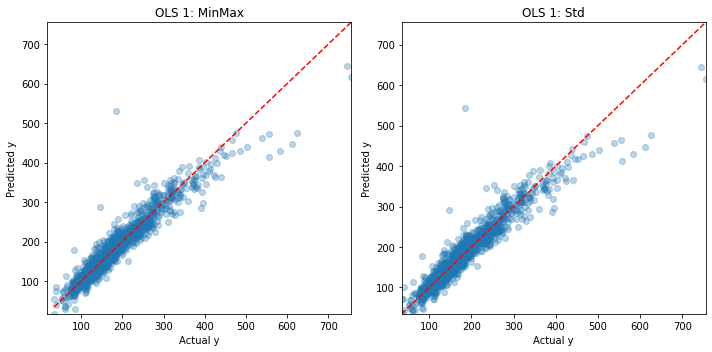

In [20]:
# See predicted versus actual (minmax, std)
y_pred_1_minmax = ols_1_minmax.predict(X1_minmax)
y_pred_1_std = ols_1_std.predict(X1_std)
mpp.pred_vs_actual(y, [y_pred_1_minmax, y_pred_1_std], ["OLS 1: MinMax", "OLS 1: Std"])

In [21]:
# Print metrics from Leave-One-Out Cross Validation (minmax)
ols_1_minmax_residuals, ols_1_minmax_residuals_ratio, ols_1_minmax_r2, ols_1_minmax_coef = return_loocv(X1_minmax.values, y.values)
print_metrics(ols_1_minmax_residuals, ols_1_minmax_residuals_ratio, ols_1_minmax_r2)

MSE: 931.0674524052346
RMSE: 30.51339791641099
MAE: 16.301012015339175
MPE: 1.073073848074385
MAPE: 9.511823745042705
R2: 0.8523705940344807


In [22]:
# Print metrics from Leave-One-Out Cross Validation (std)
ols_1_std_residuals, ols_1_std_residuals_ratio, ols_1_std_r2, ols_1_std_coef = return_loocv(X1_std.values, y.values)
print_metrics(ols_1_std_residuals, ols_1_std_residuals_ratio, ols_1_std_r2)

MSE: 824.6470659555689
RMSE: 28.71666878235651
MAE: 16.147296847309224
MPE: 1.1464641076350084
MAPE: 9.374317504502235
R2: 0.8692445362967727


# Model 2: OLS with non-linear target feature

Take log(y) to account for non-linear relationship seen in Model 1

In [23]:
# Loop to drop feature with maximum p-value until all p-values are <= 0.05 (minmax)
X2_minmax = X0_minmax.copy()
log_y = np.log(y)

exit_loop = False

while not exit_loop:
    ols_model = sm.OLS(log_y, X2_minmax).fit()
    p_values = ols_model.pvalues
    max_p_value_feature = p_values.idxmax()
    if p_values[max_p_value_feature] <= 0.05:
        exit_loop = True
    else:
        X2_minmax = X2_minmax.drop(max_p_value_feature, axis=1)

ols_2_minmax = sm.OLS(log_y, X2_minmax).fit()
ols_2_minmax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     267.2
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:03:33   Log-Likelihood:                 1166.5
No. Observations:                1460   AIC:                            -2201.
Df Residuals:                    1394   BIC:                            -1852.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.1114      0.042     98.065      0.000       4.029       4.194
LotArea                   0.4122      0.087      4.722      0.000       0.241       0.583
OverallCond               0.3455      0.027     12.834      0.000       0.293       0.398
BsmtFinSF1                0.7804      0.080      9.696      0.000       0.623       0.938
BsmtFinSF2                0.1469      0.033      4.502      0.000       0.083       0.211
BsmtUnfSF                 0.2152      0.029      7.392      0.000       0.158       0.272
HeatingQC                 0.0562      0.016      3.455      0.001       0.024       0.088
GrLivArea                 1.4292      0.066     21.781      0.000       1.300       1.558
BsmtFullBath              0.1056      0.024      4.327      0.000       0.058       0.154
FullBath                  0.0624      0.028      2.263      0.024       0.008       0.117
HalfBath                  0.0354      0.016      2.165      0.031       0.003       0.068
KitchenAbvGr             -0.2197      0.048     -4.608      0.000      -0.313      -0.126
Functional                0.2319      0.029      8.072      0.000       0.176       0.288
Fireplaces                0.0951      0.017      5.508      0.000       0.061       0.129
GarageCars                0.1904      0.027      6.980      0.000       0.137       0.244
WoodDeckSF                0.0919      0.022      4.090      0.000       0.048       0.136
EnclosedPorch             0.0881      0.030      2.924      0.004       0.029       0.147
ScreenPorch               0.1246      0.027      4.656      0.000       0.072       0.177
HomeAge                  -0.3230      0.034     -9.601      0.000      -0.389      -0.257
GenQual                   0.3502      0.035     10.059      0.000       0.282       0.419
HasProxArtery            -0.0782      0.018     -4.456      0.000      -0.113      -0.044
HasProxFeedr             -0.0496      0.013     -3.791      0.000      -0.075      -0.024
HasProxPosN              -0.1026      0.027     -3.843      0.000      -0.155      -0.050
HasProxRRAe              -0.1076      0.033     -3.260      0.001      -0.172      -0.043
MSZoning_C (all)         -0.4299      0.038    -11.242      0.000      -0.505      -0.355
MSZoning_RM              -0.0520      0.011     -4.729      0.000      -0.074      -0.030
LandContour_Bnk          -0.0368      0.015     -2.412      0.016      -0.067      -0.007
LotConfig_CulDSac         0.0398      0.013      3.178      0.002       0.015       0.064
LandSlope_Sev            -0.1204      0.041     -2.916      0.004      -0.201      -0.039
Neighborhood_BrkSide      0.0353      0.017      2.126      0.034       0.003       0.068
Neighborhood_ClearCr      0.0570      0.024      2.396      0.017       0.010       0.104
Neighborhood_Crawfor   

In [24]:
# Loop to drop feature with maximum p-value until all p-values are <= 0.05 (std)
X2_std = X0_std.copy()
log_y = np.log(y)

exit_loop = False

while not exit_loop:
    ols_model = sm.OLS(log_y, X2_std).fit()
    p_values = ols_model.pvalues
    max_p_value_feature = p_values.idxmax()
    if p_values[max_p_value_feature] <= 0.05:
        exit_loop = True
    else:
        X2_std = X2_std.drop(max_p_value_feature, axis=1)

ols_2_std = sm.OLS(log_y, X2_std).fit()
ols_2_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     282.8
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:03:39   Log-Likelihood:                 1159.9
No. Observations:                1460   AIC:                            -2196.
Df Residuals:                    1398   BIC:                            -1868.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.1163      0.003   1749.700      0.000       5.111       5.122
LotArea                   0.0190      0.004      4.689      0.000       0.011       0.027
OverallCond               0.0493      0.004     13.207      0.000       0.042       0.057
BsmtFinSF1                0.0622      0.007      9.556      0.000       0.049       0.075
BsmtFinSF2                0.0165      0.004      4.605      0.000       0.009       0.023
BsmtUnfSF                 0.0393      0.005      7.153      0.000       0.029       0.050
HeatingQC                 0.0127      0.004      3.256      0.001       0.005       0.020
GrLivArea                 0.1417      0.006     21.859      0.000       0.129       0.154
BsmtFullBath              0.0182      0.004      4.312      0.000       0.010       0.026
FullBath                  0.0120      0.005      2.371      0.018       0.002       0.022
HalfBath                  0.0085      0.004      2.077      0.038       0.000       0.017
KitchenAbvGr             -0.0166      0.003     -4.774      0.000      -0.023      -0.010
Functional                0.0247      0.003      7.735      0.000       0.018       0.031
Fireplaces                0.0203      0.004      5.455      0.000       0.013       0.028
GarageCars                0.0368      0.005      7.216      0.000       0.027       0.047
WoodDeckSF                0.0127      0.003      3.864      0.000       0.006       0.019
EnclosedPorch             0.0097      0.003      2.915      0.004       0.003       0.016
ScreenPorch               0.0135      0.003      4.348      0.000       0.007       0.020
HomeAge                  -0.0706      0.007     -9.606      0.000      -0.085      -0.056
GenQual                   0.0622      0.006      9.978      0.000       0.050       0.074
HasProxArtery            -0.0133      0.003     -4.253      0.000      -0.019      -0.007
HasProxFeedr             -0.0112      0.003     -3.643      0.000      -0.017      -0.005
HasProxPosN              -0.0116      0.003     -3.836      0.000      -0.018      -0.006
HasProxRRAe              -0.0096      0.003     -3.196      0.001      -0.015      -0.004
MSZoning_C (all)         -0.0356      0.003    -11.283      0.000      -0.042      -0.029
MSZoning_RM              -0.0203      0.004     -5.200      0.000      -0.028      -0.013
LandContour_Bnk          -0.0077      0.003     -2.477      0.013      -0.014      -0.002
LotConfig_CulDSac         0.0100      0.003      3.257      0.001       0.004       0.016
LandSlope_Sev            -0.0118      0.004     -3.037      0.002      -0.019      -0.004
Neighborhood_BrkSide      0.0070      0.003      2.153      0.031       0.001       0.013
Neighborhood_ClearCr      0.0079      0.003      2.431      0.015       0.002       0.014
Neighborhood_Crawfor   

In [25]:
# Check variance inflation factor (minmax)
check_vif(X2_minmax)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,207.0
1,LotArea,2.0
2,OverallCond,2.0
3,BsmtFinSF1,5.0
4,BsmtFinSF2,1.0
5,BsmtUnfSF,4.0
6,HeatingQC,2.0
7,GrLivArea,5.0
8,BsmtFullBath,2.0
9,FullBath,3.0


In [26]:
# Check variance inflation factor (std)
check_vif(X2_std)

/Users/allisondzubak/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,1.0
1,LotArea,2.0
2,OverallCond,2.0
3,BsmtFinSF1,5.0
4,BsmtFinSF2,1.0
5,BsmtUnfSF,4.0
6,HeatingQC,2.0
7,GrLivArea,5.0
8,BsmtFullBath,2.0
9,FullBath,3.0


Look at model 2 predictions

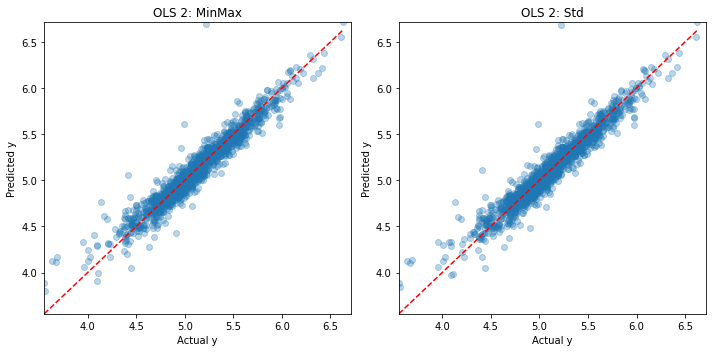

In [27]:
# See predicted versus actual (minmax, std)
y_pred_2_minmax = ols_2_minmax.predict(X2_minmax)
y_pred_2_std = ols_2_std.predict(X2_std)
mpp.pred_vs_actual(log_y, [y_pred_2_minmax, y_pred_2_std], ["OLS 2: MinMax", "OLS 2: Std"])

In [28]:
# Print metrics from Leave-One-Out Cross Validation (minmax)
ols_2_minmax_residuals, ols_2_minmax_residuals_ratio, ols_2_minmax_r2, ols_2_minmax_coef = return_loocv(X2_minmax.values, log_y.values, exp=True)
print_metrics(ols_2_minmax_residuals, ols_2_minmax_residuals_ratio, ols_2_minmax_r2)

MSE: 2982.899237402721
RMSE: 54.615924760116634
MAE: 15.52748368980722
MPE: 1.5624784203449786
MAPE: 9.060375438600719
R2: 0.5270335770677312


In [29]:
# Print metrics from Leave-One-Out Cross Validation (std)
ols_2_std_residuals, ols_2_std_residuals_ratio, ols_2_std_r2, ols_2_std_coef = return_loocv(X2_std.values, log_y.values, exp=True)
print_metrics(ols_2_std_residuals, ols_2_std_residuals_ratio, ols_2_std_r2)

MSE: 978.7397693234308
RMSE: 31.284816913695224
MAE: 14.603641878694713
MPE: 0.7124384220763976
MAPE: 8.465290807243694
R2: 0.8448117047086297


# Model 3 : Linear model with Lasso regularization

In [30]:
# Model 3: Use LassoCV for feature selection
X3_minmax = X0_minmax.copy()
X3_std = X0_std.copy()
k = len(y) - 1

In [31]:
# Set wide alpha range to start
alphas = np.logspace(-4, 1, 10)

In [32]:
# Perform LassoCV over wide alpha range for minmax scaling
lasso_model_3_minmax = LassoCV(alphas=alphas, cv=k, max_iter=30000)
lasso_model_3_minmax.fit(X3_minmax, y)

LassoCV(alphas=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
        cv=1459, max_iter=30000)

In [33]:
# Perform LassoCV over wide alpha range for std scaling
lasso_model_3_std = LassoCV(alphas=alphas, cv=k, max_iter=30000)
lasso_model_3_std.fit(X3_std, y)

LassoCV(alphas=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
        cv=1459, max_iter=30000)

In [34]:
# Get the alpha values and mse values for those alphas (minmax)
print(lasso_model_3_minmax.alphas_)
np.mean(lasso_model_3_minmax.mse_path_, axis=1)

[1.00000000e+01 2.78255940e+00 7.74263683e-01 2.15443469e-01
 5.99484250e-02 1.66810054e-02 4.64158883e-03 1.29154967e-03
 3.59381366e-04 1.00000000e-04]


array([5127.86305209, 1897.18077834, 1181.56531491,  966.68107073,
        949.55824963, 1016.77757536, 1076.53721127, 1078.69512126,
       1670.79273523, 2229.7752639 ])

In [35]:
# Get the alpha values and mse values for those alphas (std)
print(lasso_model_3_std.alphas_)
np.mean(lasso_model_3_std.mse_path_, axis=1)

[1.00000000e+01 2.78255940e+00 7.74263683e-01 2.15443469e-01
 5.99484250e-02 1.66810054e-02 4.64158883e-03 1.29154967e-03
 3.59381366e-04 1.00000000e-04]


array([1488.6023558 , 1077.41182581,  974.64145927, 1025.60009138,
       1077.37585769, 1281.12698312, 2068.92430394, 2425.08157706,
       2537.58179593, 2569.75858504])

In [36]:
# Narrow alpha range
alphas_minmax = np.linspace(0.01, .2, 10)
alphas_std = np.linspace(0.2, 2, 10)

In [37]:
# Perform LassoCV over narrower alpha range for minmax scaling
lasso_model_3_minmax = LassoCV(alphas=alphas_minmax, cv=k, max_iter=30000)
lasso_model_3_minmax.fit(X3_minmax, y)

LassoCV(alphas=array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
        cv=1459, max_iter=30000)

In [38]:
# Perform LassoCV over wide alpha range for std scaling
lasso_model_3_std = LassoCV(alphas=alphas_std, cv=k, max_iter=30000)
lasso_model_3_std.fit(X3_std, y)

LassoCV(alphas=array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
        cv=1459, max_iter=30000)

In [39]:
# Get the alpha values and mse values for those alphas (minmax)
print(lasso_model_3_minmax.alphas_)
np.mean(lasso_model_3_minmax.mse_path_, axis=1)

[0.2        0.17888889 0.15777778 0.13666667 0.11555556 0.09444444
 0.07333333 0.05222222 0.03111111 0.01      ]


array([ 959.5357203 ,  952.23020367,  944.21135759,  938.45076213,
        932.25832196,  934.46322964,  942.29005627,  954.25776215,
        976.3732659 , 1047.3179032 ])

In [40]:
# Get the alpha values and mse values for those alphas (std)
print(lasso_model_3_std.alphas_)
np.mean(lasso_model_3_std.mse_path_, axis=1)

[2.  1.8 1.6 1.4 1.2 1.  0.8 0.6 0.4 0.2]


array([1023.91582532, 1012.15992451,  999.8251362 ,  990.08951786,
        981.38670534,  974.87666723,  974.933218  ,  981.74119557,
       1000.26285513, 1029.25721462])

In [41]:
# Narrow alpha range
alphas_minmax = np.linspace(0.09, .14, 10)
alphas_std = np.linspace(0.6, 1.2, 10)

In [42]:
# Perform LassoCV over narrower alpha range for minmax scaling
lasso_model_3_minmax = LassoCV(alphas=alphas_minmax, cv=k, max_iter=30000)
lasso_model_3_minmax.fit(X3_minmax, y)

LassoCV(alphas=array([0.09      , 0.09555556, 0.10111111, 0.10666667, 0.11222222,
       0.11777778, 0.12333333, 0.12888889, 0.13444444, 0.14      ]),
        cv=1459, max_iter=30000)

In [43]:
# Perform LassoCV over narrower alpha range for std scaling
lasso_model_3_std = LassoCV(alphas=alphas_std, cv=k, max_iter=30000)
lasso_model_3_std.fit(X3_std, y)

LassoCV(alphas=array([0.6       , 0.66666667, 0.73333333, 0.8       , 0.86666667,
       0.93333333, 1.        , 1.06666667, 1.13333333, 1.2       ]),
        cv=1459, max_iter=30000)

In [44]:
# Get the alpha values and mse values for those alphas (minmax)
print(lasso_model_3_minmax.alphas_)
np.mean(lasso_model_3_minmax.mse_path_, axis=1)

[0.14       0.13444444 0.12888889 0.12333333 0.11777778 0.11222222
 0.10666667 0.10111111 0.09555556 0.09      ]


array([939.02993953, 937.93413506, 935.89987663, 934.23519376,
       932.79680403, 931.8317337 , 931.74092706, 932.48208893,
       934.02329153, 936.12784711])

In [45]:
# Get the alpha values and mse values for those alphas (std)
print(lasso_model_3_std.alphas_)
np.mean(lasso_model_3_std.mse_path_, axis=1)

[1.2        1.13333333 1.06666667 1.         0.93333333 0.86666667
 0.8        0.73333333 0.66666667 0.6       ]


array([981.37851587, 978.52584787, 976.17155378, 974.88436791,
       974.80970974, 974.85776221, 974.9483321 , 975.151581  ,
       977.60120456, 981.76203632])

In [46]:
# Get the best alpha
best_alpha_minmax = lasso_model_3_minmax.alpha_
best_alpha_std = lasso_model_3_std.alpha_
print(f"best alpha minmax: {best_alpha_minmax}")
print(f"best alpha std: {best_alpha_std}")

best alpha minmax: 0.10666666666666667
best alpha std: 0.9333333333333333


Look at Model 3 predictions

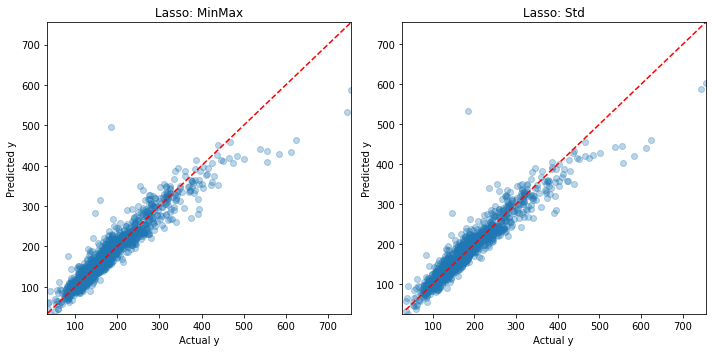

In [47]:
lasso_model_3_minmax = Lasso(alpha=best_alpha_minmax)
lasso_model_3_std = Lasso(alpha=best_alpha_std)
lasso_model_3_minmax.fit(X3_minmax, y)
lasso_model_3_std.fit(X3_std,y)
y_pred_3_minmax = lasso_model_3_minmax.predict(X3_minmax)
y_pred_3_std = lasso_model_3_std.predict(X3_std)
mpp.pred_vs_actual(y, [y_pred_3_minmax, y_pred_3_std], ["Lasso: MinMax", "Lasso: Std"])

In [48]:
# Print metrics from Leave-One-Out Cross Validation (minmax)
lasso_3_minmax_residuals, lasso_3_minmax_residuals_ratio, lasso_3_minmax_r2, lasso_3_minmax_coef = return_loocv(X3_minmax.values, y.values, lasso=True, alpha=best_alpha_minmax)
print_metrics(lasso_3_minmax_residuals, lasso_3_minmax_residuals_ratio, lasso_3_minmax_r2)

MSE: 931.1628202919778
RMSE: 30.51496059790964
MAE: 17.096062867141793
MPE: 1.6871608361097752
MAPE: 9.793154311831817
R2: 0.8523554725688643


In [49]:
# Print metrics from Leave-One-Out Cross Validation (std)
lasso_3_std_residuals, lasso_3_std_residuals_ratio, lasso_3_std_r2, lasso_3_std_coef = return_loocv(X3_std.values, y.values, lasso=True, alpha=best_alpha_std)
print_metrics(lasso_3_std_residuals, lasso_3_std_residuals_ratio, lasso_3_std_r2)

MSE: 974.2182618478603
RMSE: 31.212469653134793
MAE: 16.690986931947375
MPE: 1.7264203656191364
MAPE: 9.578790269423862
R2: 0.8455286317808441


# Model Comparison

In [50]:
# Names of the models for the plot
y_pred_names = ["Ordinary Least Squares", "Ordinary Least Squares +\nNonlinearity Incorporated", "Linear Model + Lasso"]

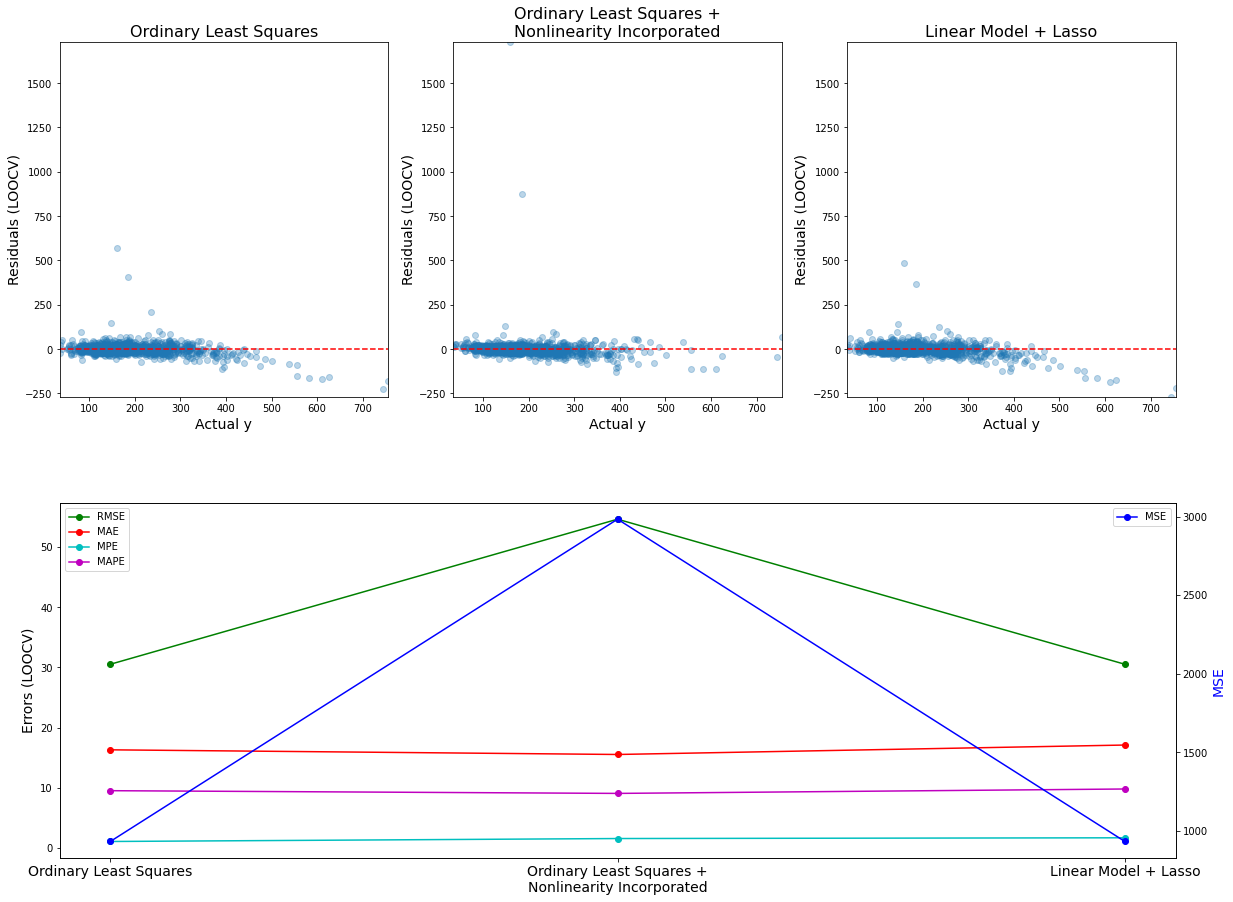

In [62]:
# Create a 2x3 grid of subplots, where the first row is for the scatter plots and the second row is for the stacked line plots
def model_comparison(y, residuals, y_pred_names, mse_values, rmse_values, mae_values, mpe_values, mape_values, save_fig=False, fig_pathname=None):
    fig = plt.figure(figsize=(20, 15), facecolor="white")
    gs = GridSpec(2, 3, height_ratios=[1, 1], hspace=0.3)

    # Determine common axis limits
    common_x_min = np.min(y)
    common_x_max = np.max(y)
    flat_residuals = (value for sublist in residuals for value in sublist)
    flat_residuals_list = list(flat_residuals)
    common_y_min = min(flat_residuals_list)
    common_y_max = max(flat_residuals_list)

    # Scatter plot for Model 1 (Top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y, residuals[0], alpha=0.3)
    ax1.set_xlabel("Actual y", fontsize=14)
    ax1.set_ylabel("Residuals (LOOCV)", fontsize=14)
    ax1.axhline(0, color="red", linestyle="--")
    ax1.set_xlim(common_x_min, common_x_max)
    ax1.set_ylim(common_y_min, common_y_max)
    ax1.set_title(y_pred_names[0], fontsize=16)

    # Scatter plot for Model 2 (Top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(y, residuals[1], alpha=0.3)
    ax2.set_xlabel("Actual y", fontsize=14)
    ax2.set_ylabel("Residuals (LOOCV)", fontsize=14)
    ax2.axhline(0, color="red", linestyle="--")
    ax2.set_xlim(common_x_min, common_x_max)
    ax2.set_ylim(common_y_min, common_y_max)
    ax2.set_title(y_pred_names[1], fontsize=16)

    # Scatter plot for Model 3 (Top right)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.scatter(y, residuals[2], alpha=0.3)
    ax3.set_xlabel("Actual y", fontsize=14)
    ax3.set_ylabel("Residuals (LOOCV)", fontsize=14)
    ax3.axhline(0, color="red", linestyle="--")
    ax3.set_xlim(common_x_min, common_x_max)
    ax3.set_ylim(common_y_min, common_y_max)
    ax3.set_title(y_pred_names[2], fontsize=16)

    # Plot the stacked line plot below the scatter plots
    ax4 = fig.add_subplot(gs[1, :])

    # Create a secondary y-axis for MSE
    ax4b = ax4.twinx()

    ax4.plot(y_pred_names, rmse_values, marker="o", linestyle="-", color="g", label="RMSE")
    ax4.plot(y_pred_names, mae_values, marker="o", linestyle="-", color="r", label="MAE")
    ax4.plot(y_pred_names, mpe_values, marker="o", linestyle="-", color="c", label="MPE")
    ax4.plot(y_pred_names, mape_values, marker="o", linestyle="-", color="m", label="MAPE")
    ax4b.plot(y_pred_names, mse_values, marker="o", linestyle="-", color="b", label="MSE")

    ax4.tick_params(axis="x", labelsize=14)
    ax4.set_ylabel("Errors (LOOCV)", fontsize=14)
    ax4b.set_ylabel("MSE", color="b", fontsize=14)
    ax4.legend(loc="upper left")
    ax4b.legend(loc="upper right")


    if save_fig:
        plt.savefig(fig_pathname)

    # Show the plots
    plt.show()


# Show model comparison for minmax models
residuals_minmax = ols_1_minmax_residuals, ols_2_minmax_residuals, lasso_3_minmax_residuals

ols_1_mse_minmax, ols_1_rmse_minmax, ols_1_mae_minmax, ols_1_mpe_minmax, ols_1_mape_minmax = return_metrics(ols_1_minmax_residuals, ols_1_minmax_residuals_ratio)
ols_2_mse_minmax, ols_2_rmse_minmax, ols_2_mae_minmax, ols_2_mpe_minmax, ols_2_mape_minmax = return_metrics(ols_2_minmax_residuals, ols_2_minmax_residuals_ratio)
lasso_3_mse_minmax, lasso_3_rmse_minmax, lasso_3_mae_minmax, lasso_3_mpe_minmax, lasso_3_mape_minmax = return_metrics(lasso_3_minmax_residuals, lasso_3_minmax_residuals_ratio)

mse_values_minmax = ols_1_mse_minmax, ols_2_mse_minmax, lasso_3_mse_minmax
rmse_values_minmax = ols_1_rmse_minmax, ols_2_rmse_minmax, lasso_3_rmse_minmax
mae_values_minmax = ols_1_mae_minmax, ols_2_mae_minmax, lasso_3_mae_minmax
mpe_values_minmax = ols_1_mpe_minmax, ols_2_mpe_minmax, lasso_3_mpe_minmax
mape_values_minmax = ols_1_mape_minmax, ols_2_mape_minmax, lasso_3_mape_minmax
    
model_comparison(y, residuals_minmax, y_pred_names, mse_values_minmax, rmse_values_minmax, mae_values_minmax, mpe_values_minmax, mape_values_minmax)

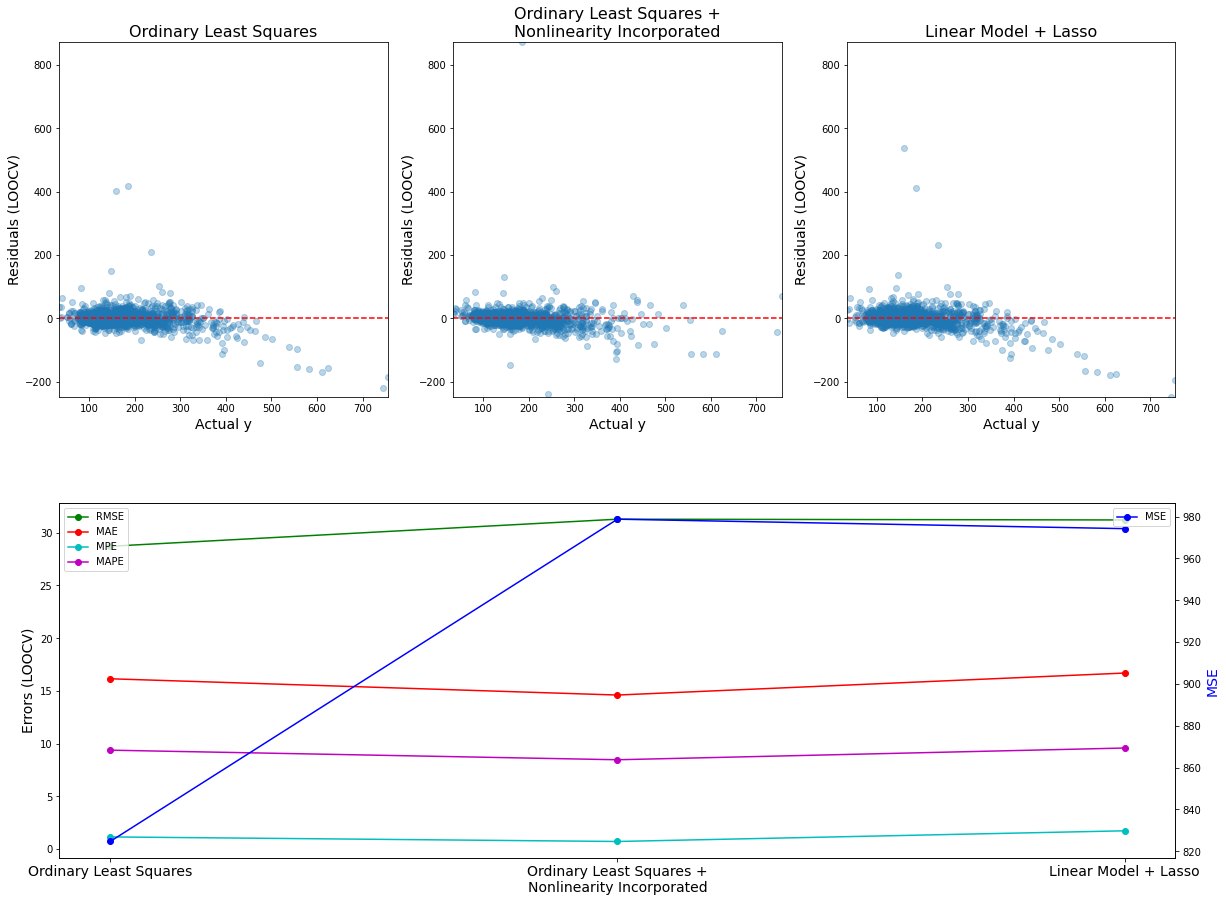

In [63]:
# Show model comparison for std models
residuals_std = ols_1_std_residuals, ols_2_std_residuals, lasso_3_std_residuals

ols_1_mse_std, ols_1_rmse_std, ols_1_mae_std, ols_1_mpe_std, ols_1_mape_std = return_metrics(ols_1_std_residuals, ols_1_std_residuals_ratio)
ols_2_mse_std, ols_2_rmse_std, ols_2_mae_std, ols_2_mpe_std, ols_2_mape_std = return_metrics(ols_2_std_residuals, ols_2_std_residuals_ratio)
lasso_3_mse_std, lasso_3_rmse_std, lasso_3_mae_std, lasso_3_mpe_std, lasso_3_mape_std = return_metrics(lasso_3_std_residuals, lasso_3_std_residuals_ratio)

mse_values_std = ols_1_mse_std, ols_2_mse_std, lasso_3_mse_std
rmse_values_std = ols_1_rmse_std, ols_2_rmse_std, lasso_3_rmse_std
mae_values_std = ols_1_mae_std, ols_2_mae_std, lasso_3_mae_std
mpe_values_std = ols_1_mpe_std, ols_2_mpe_std, lasso_3_mpe_std
mape_values_std = ols_1_mape_std, ols_2_mape_std, lasso_3_mape_std

model_comparison(y, residuals_std, y_pred_names, mse_values_std, rmse_values_std, mae_values_std, mpe_values_std, mape_values_std)

What's up with those outliers?

In [53]:
# What index is the major outlier in Model 2?
np.argmax(np.abs(ols_2_std_residuals))

523

In [54]:
# What indices are the two major outliers in Model 3?
np.argsort(np.abs(lasso_3_std_residuals))[-2:]

array([ 523, 1298])

In [55]:
# What indices are the two major outliers in Model 1?
np.argsort(np.abs(ols_1_std_residuals))[-2:]

array([1298,  523])

Where do these outliers lie in the data distribution?

In [56]:
# Outlier indices to highlight
highlight_indices = [523, 1298]  

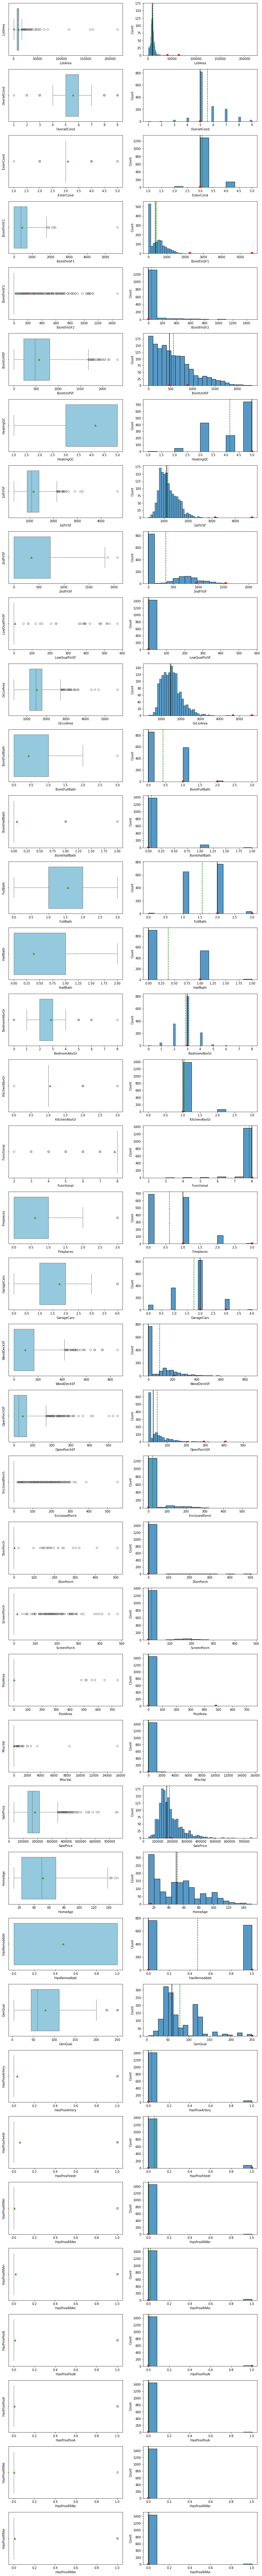

In [57]:
# Highlight outliers in histogram/boxplot
features = data.select_dtypes(include="number").columns
mpp.histogram_boxplot_df(data, features, highlight_indices=highlight_indices)    

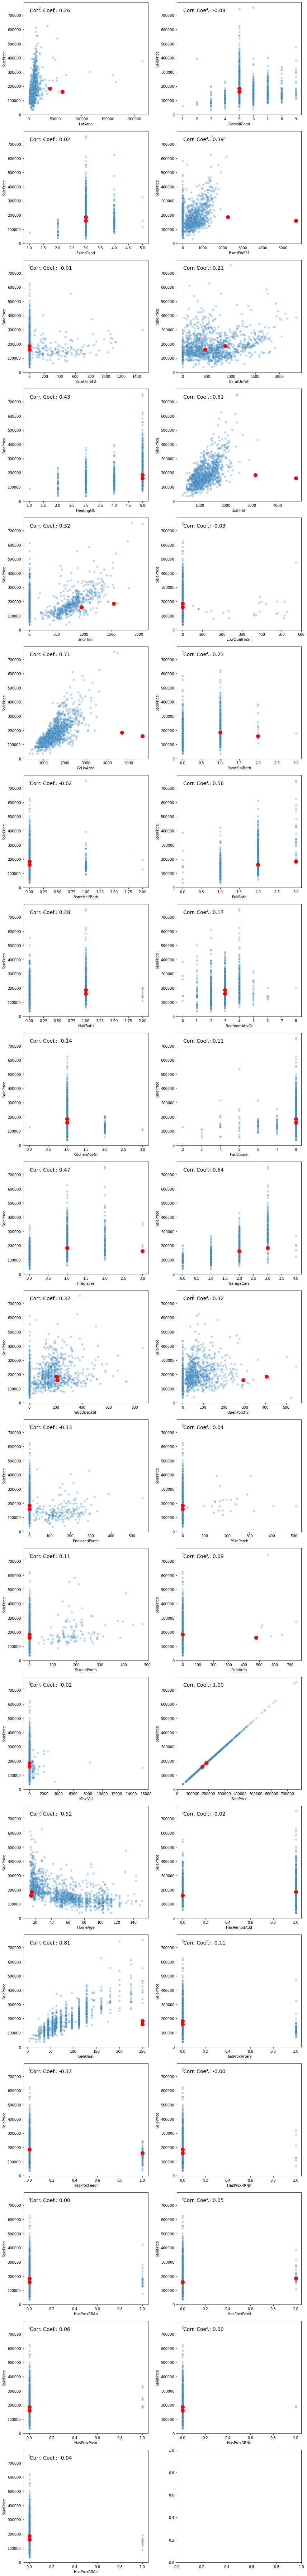

In [58]:
# Highlight numerical features of outliers in scatterplot with saleprice
selected_features = data.select_dtypes(include="number").columns.tolist()
mpp.scatter_df(data, selected_features, "SalePrice", highlight_indices=highlight_indices)

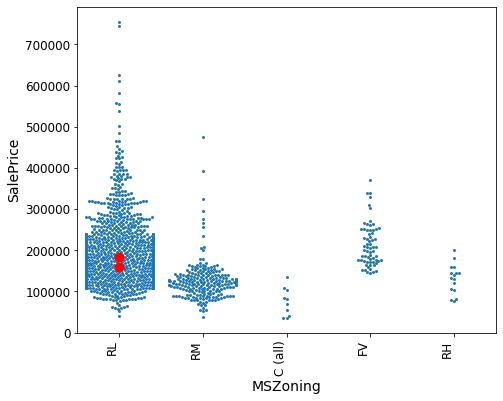

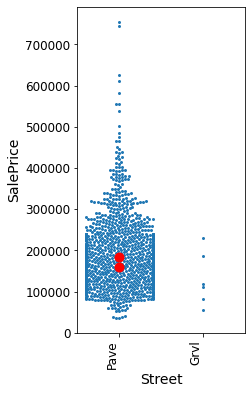

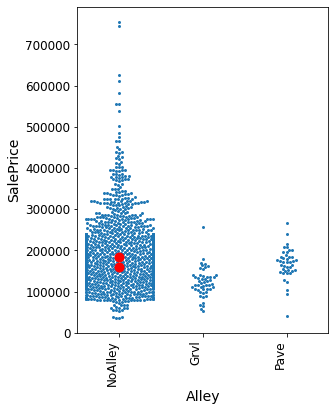

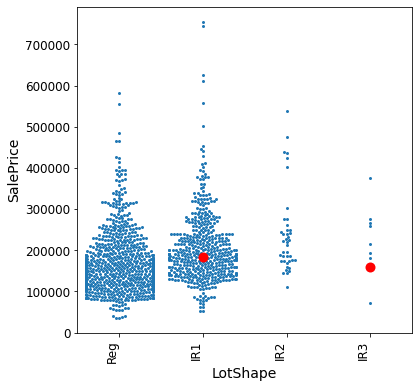

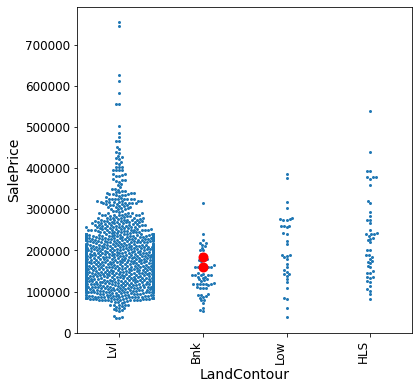

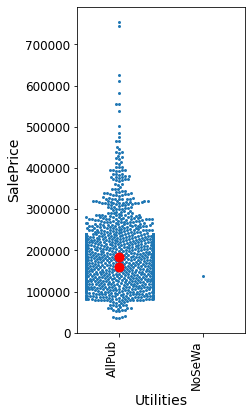

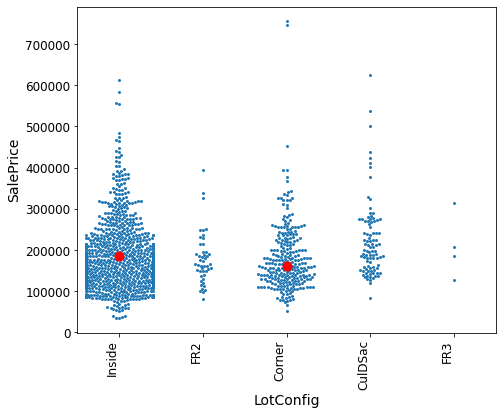

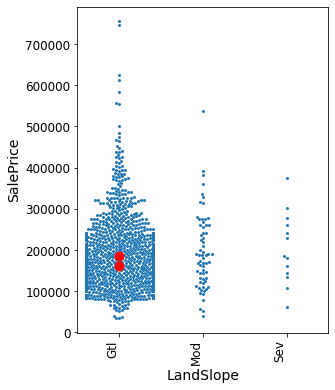

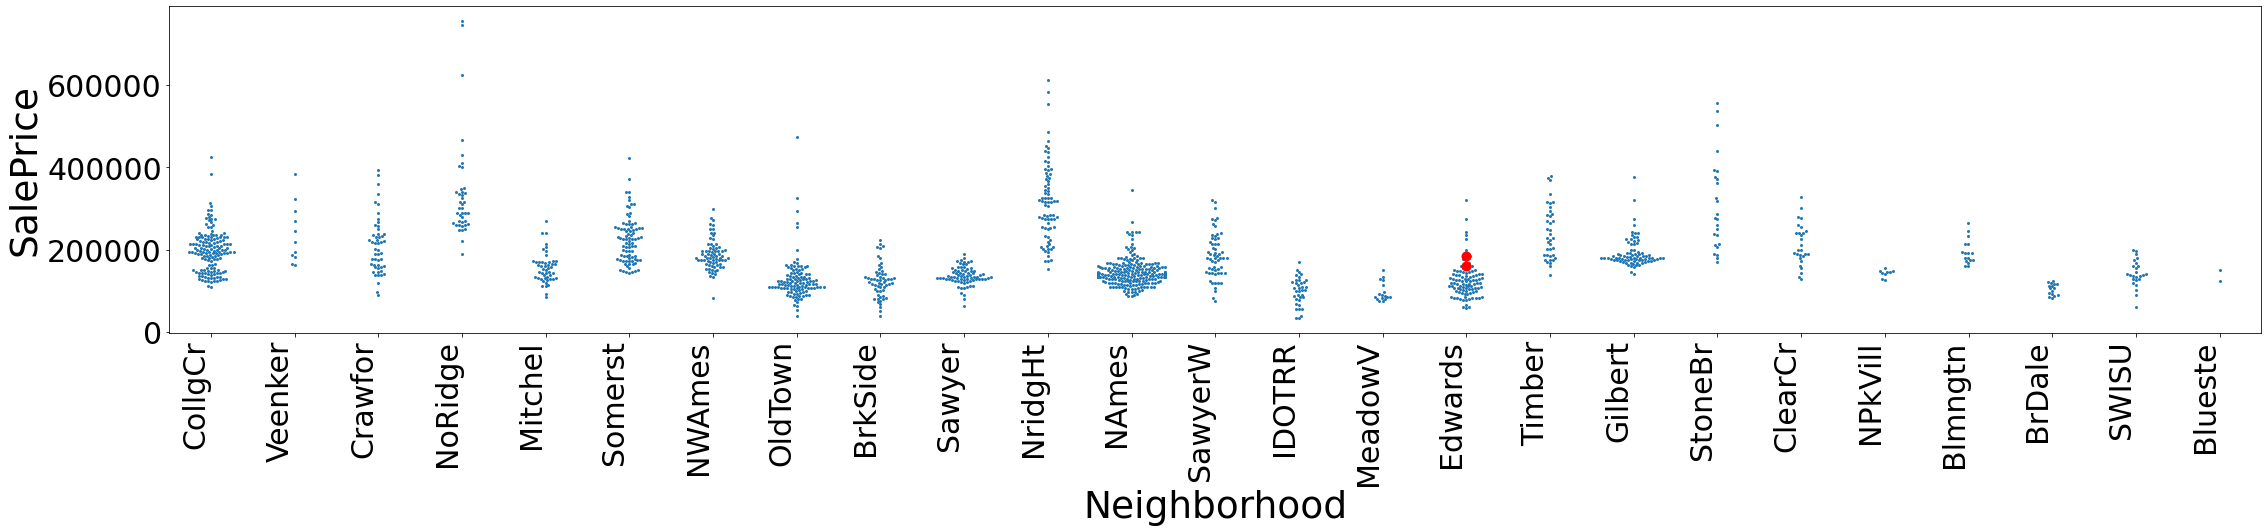

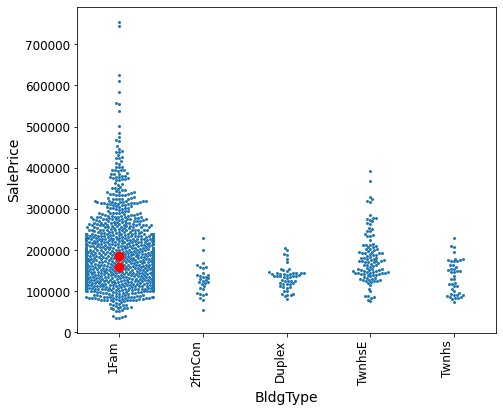

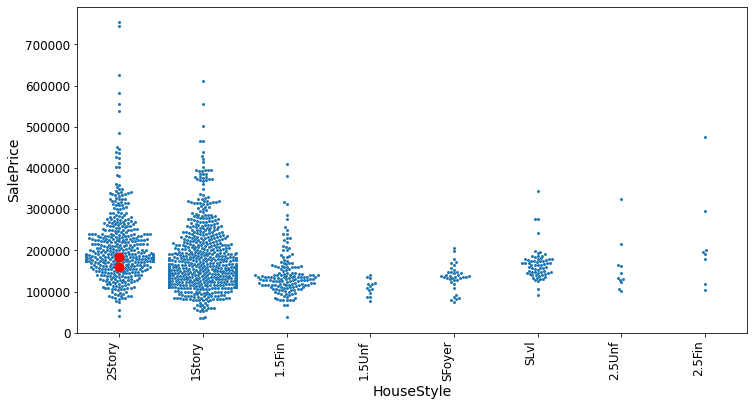

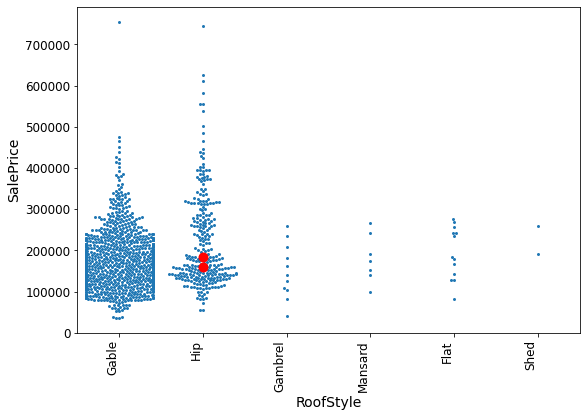

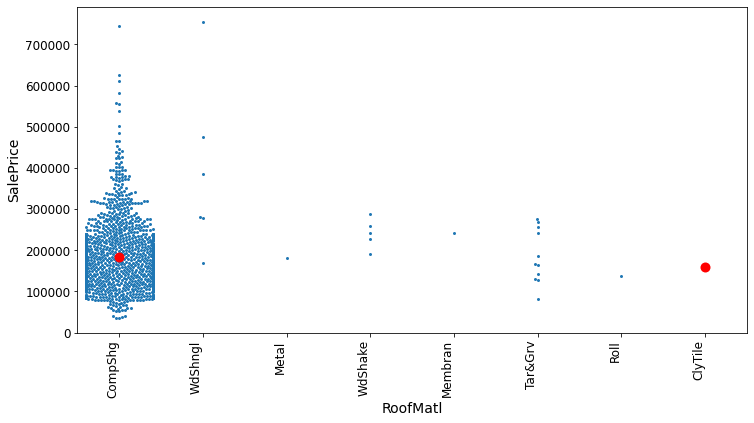

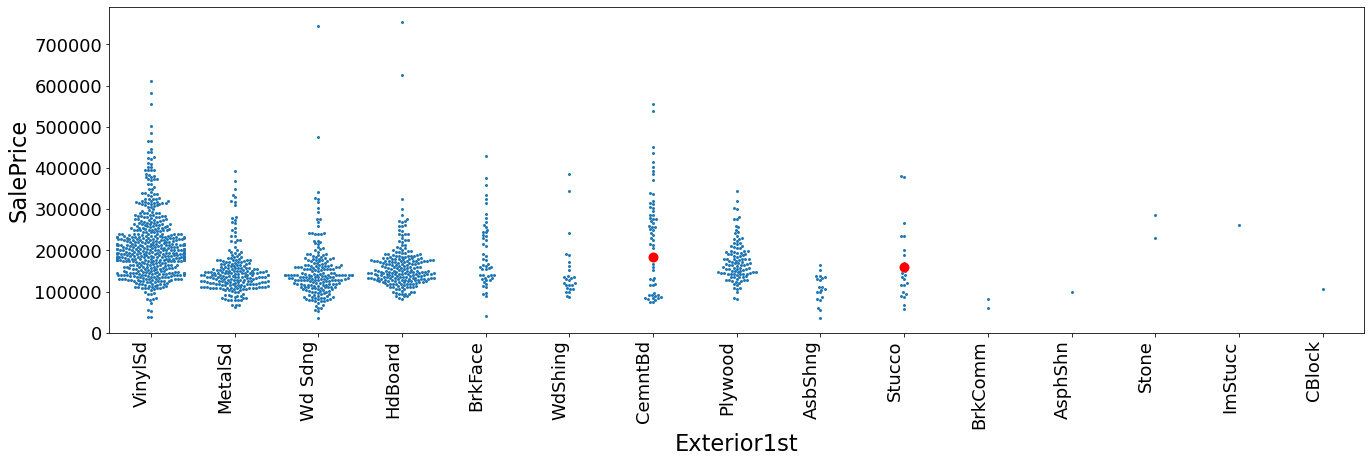

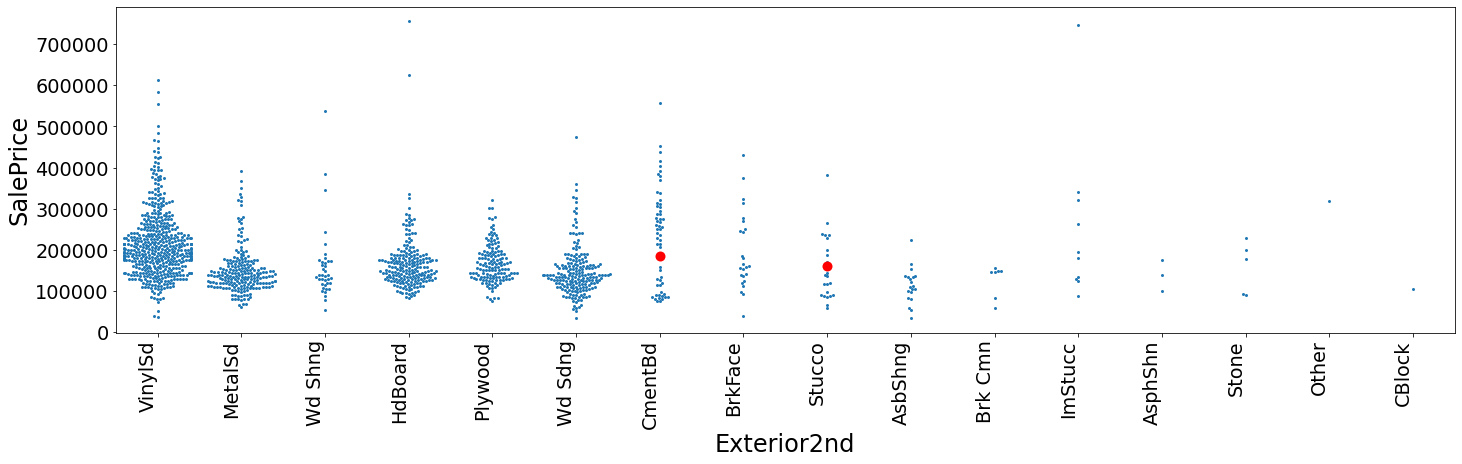

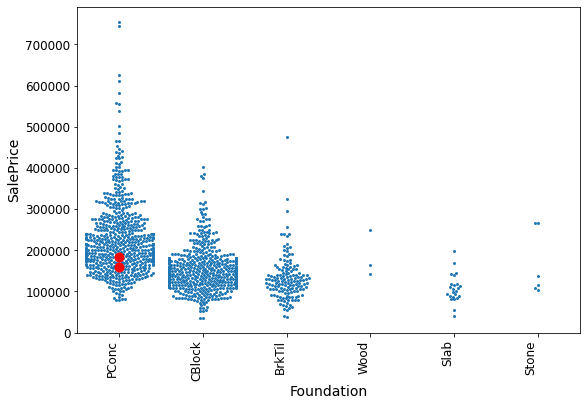

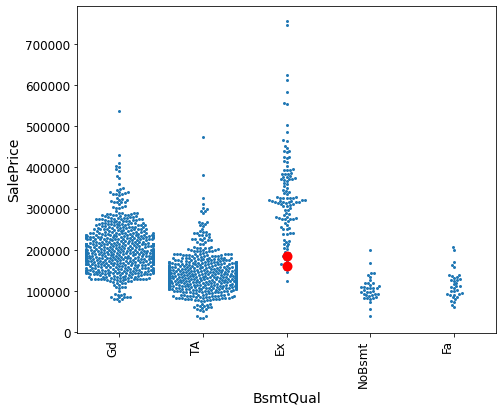

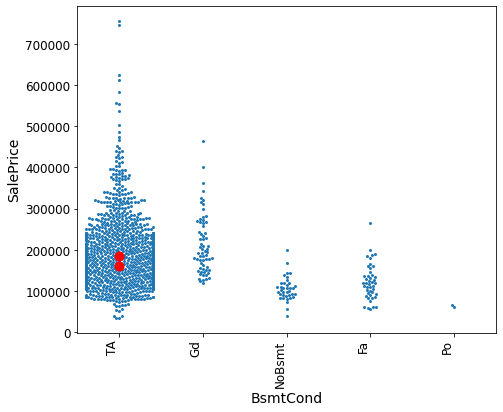

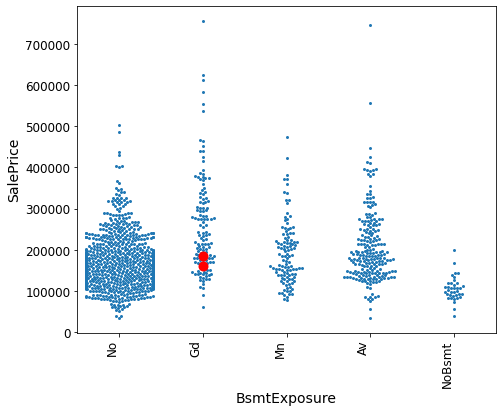

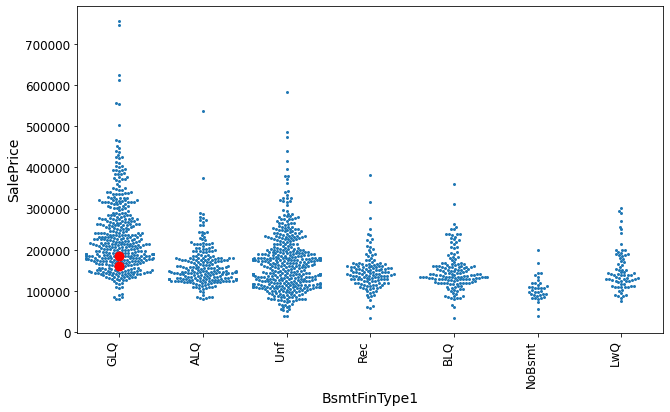

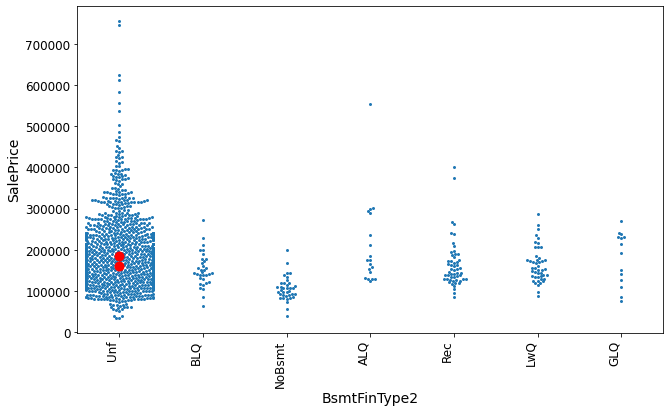

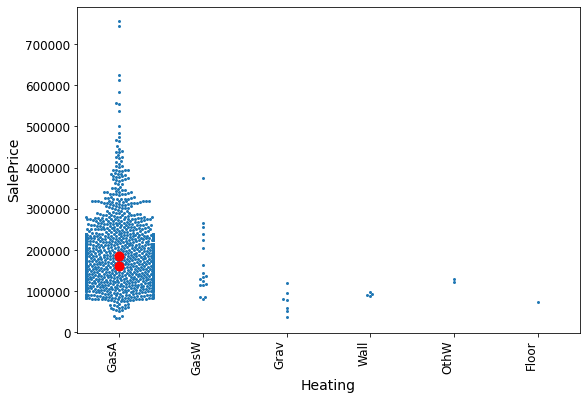

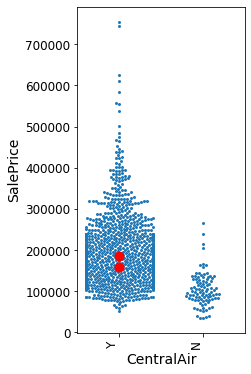

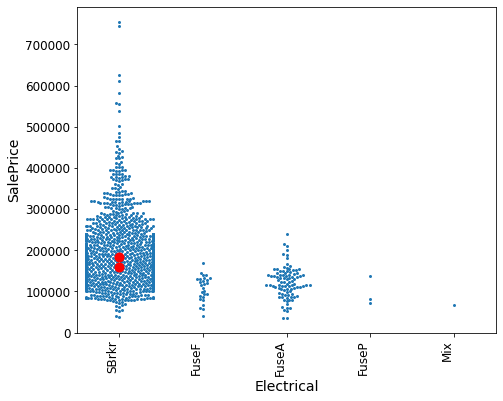

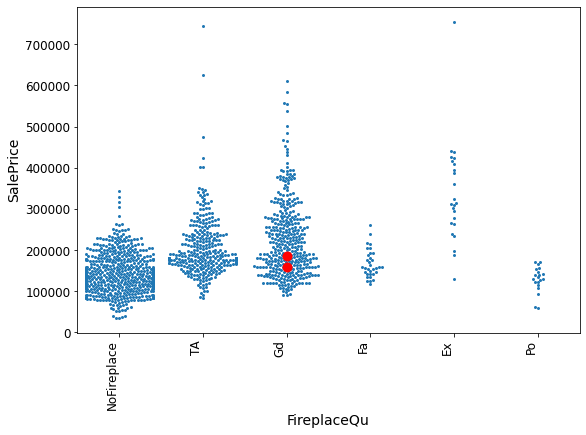

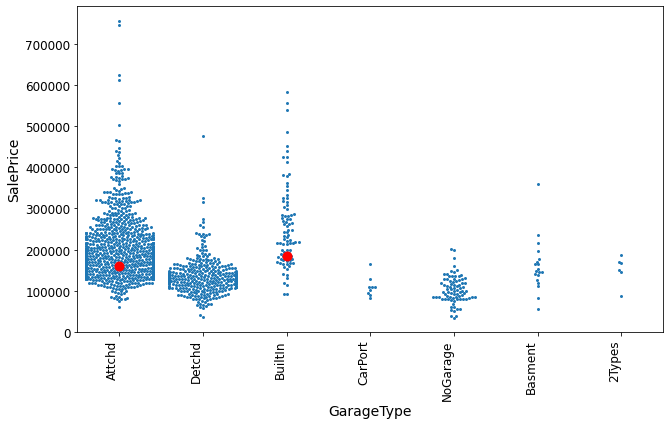

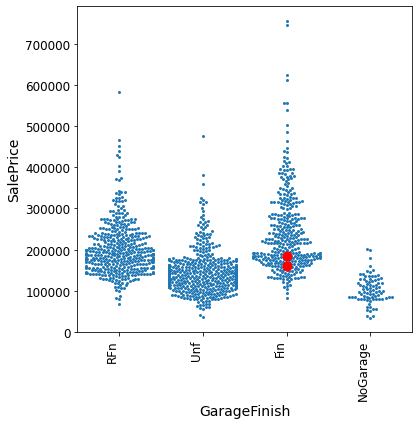

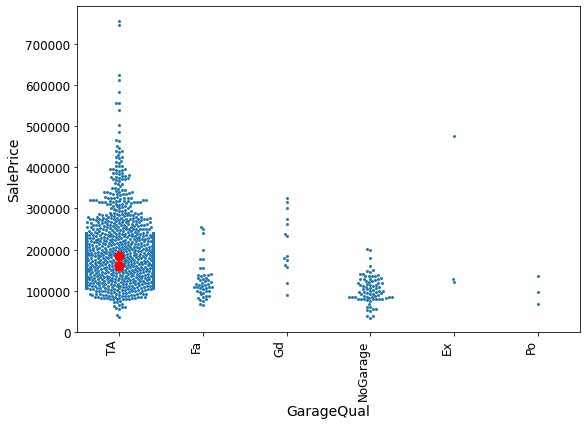

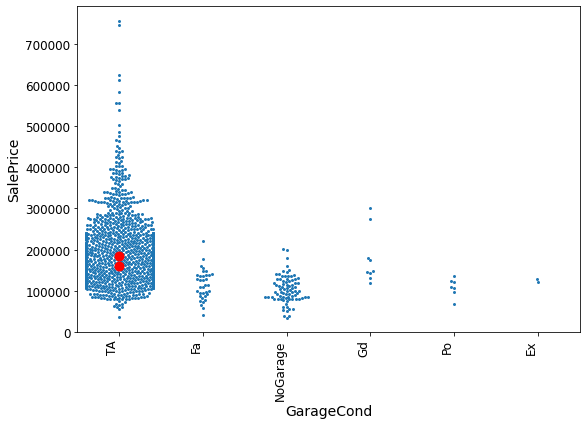

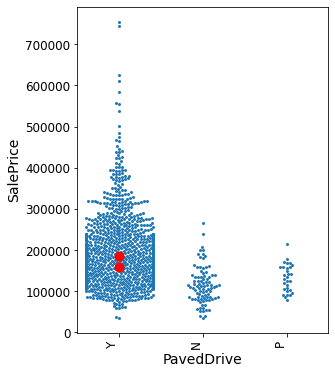

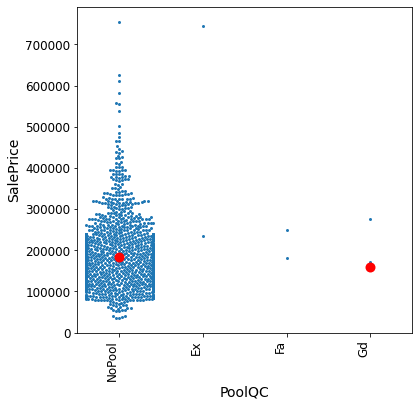

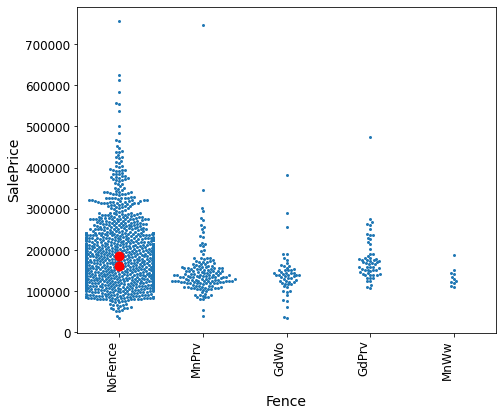

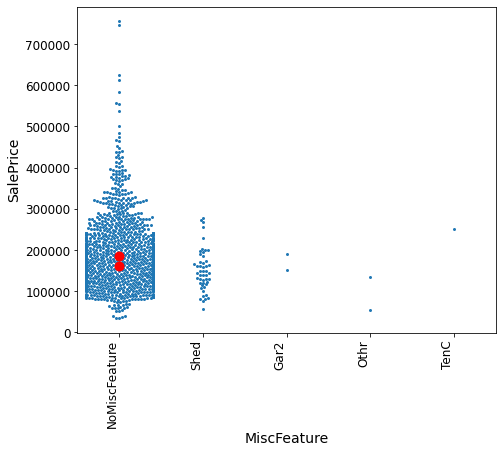

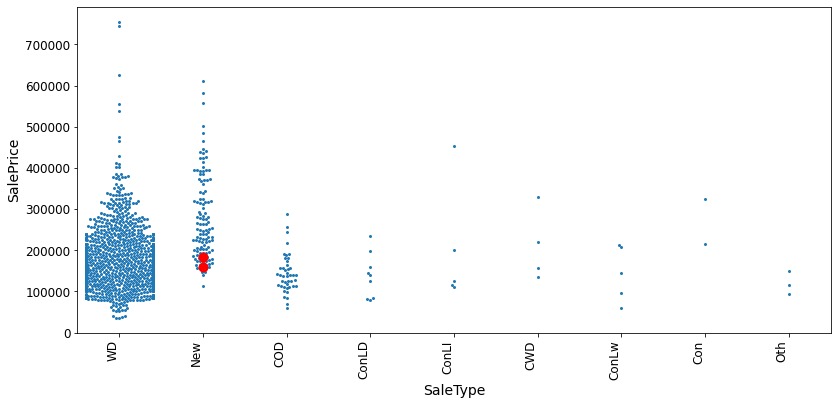

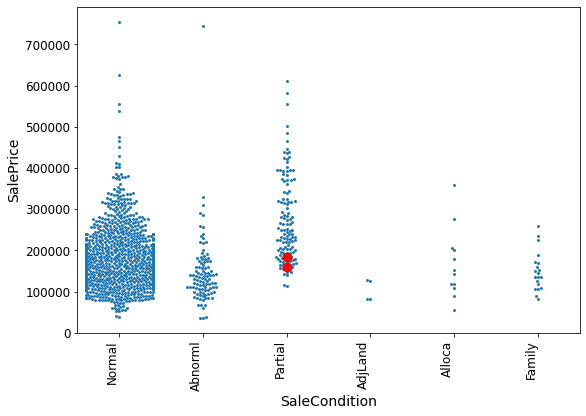

In [59]:
# Highlight categorical features of outliers in swarmplot with saleprice
mpp.swarmplot_df(data, y_feature="SalePrice", highlight_indices=highlight_indices)

How are these features being weighed? 

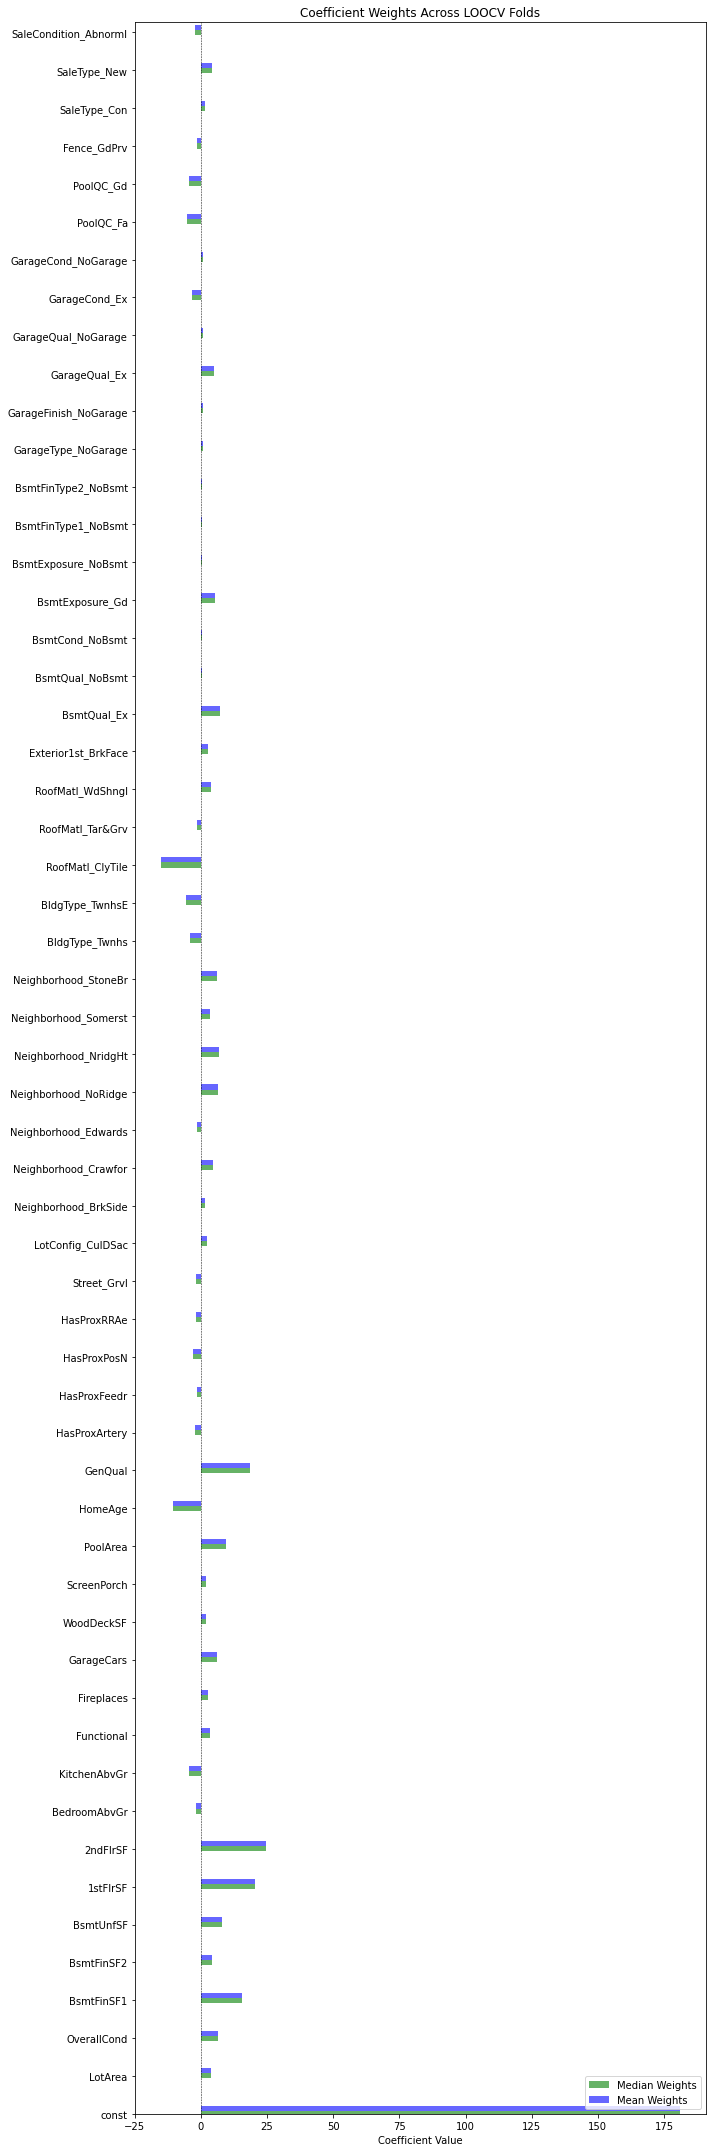

In [60]:
# Plot OLS 1 std coefficient weights from LOOCV

ols_1_std_coef_median = np.median(ols_1_std_coef, axis=0)
ols_1_std_coef_mean = np.mean(ols_1_std_coef, axis=0)
feature_names = X1_std.columns

plt.figure(figsize=(10, 30))

# Multiplier for spacing between yticks and bars
ytick_multiplier = 3

# Vertical width of each bar (adjust as needed)
bar_height = 0.4

# Horizontal positions for bars
pos_median = np.arange(len(ols_1_std_coef_median)) * ytick_multiplier
pos_mean = pos_median + 0.4  # Adjust the position slightly to separate the bars

# Plot Median Coefficients
plt.barh(pos_median, ols_1_std_coef_median, color='green', alpha=0.6, label='Median Weights', height=bar_height)

# Plot Mean Coefficients (in a different color)
plt.barh(pos_mean, ols_1_std_coef_mean, color='blue', alpha=0.6, label='Mean Weights', height=bar_height)

# Set yticks with custom positions
ytick_positions = np.arange(len(feature_names)) * ytick_multiplier
ytick_labels = feature_names
plt.yticks(ytick_positions, ytick_labels)

# Adjust the y-axis limits to remove unused white space
plt.ylim(min(pos_mean) - bar_height, max(pos_mean) + bar_height)

plt.xlabel('Coefficient Value')
plt.title('Coefficient Weights Across LOOCV Folds')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  
plt.legend(loc='lower right')
plt.tight_layout()  
plt.show()

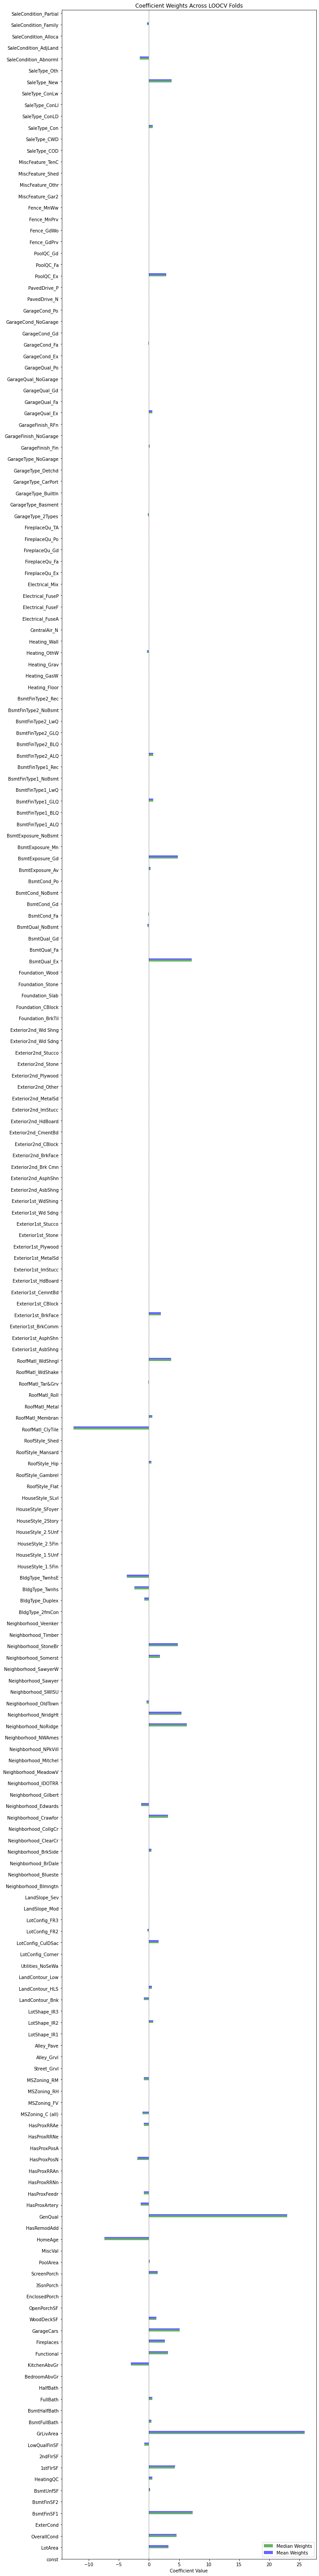

In [61]:
# Plot Lasso 3 std coefficient weights from LOOCV

lasso_3_std_coef_median = np.median(lasso_3_std_coef, axis=0)
lasso_3_std_coef_mean = np.mean(lasso_3_std_coef, axis=0)
feature_names = X3_std.columns

plt.figure(figsize=(10, 80))

# Multiplier for spacing between yticks and bars
ytick_multiplier = 3

# Vertical width of each bar (adjust as needed)
bar_height = 0.4

# Horizontal positions for bars
pos_median = np.arange(len(lasso_3_std_coef_median)) * ytick_multiplier
pos_mean = pos_median + 0.4  # Adjust the position slightly to separate the bars

# Plot Median Coefficients
plt.barh(pos_median, lasso_3_std_coef_median, color='green', alpha=0.6, label='Median Weights', height=bar_height)

# Plot Mean Coefficients (in a different color)
plt.barh(pos_mean, lasso_3_std_coef_mean, color='blue', alpha=0.6, label='Mean Weights', height=bar_height)

# Set yticks with custom positions
ytick_positions = np.arange(len(feature_names)) * ytick_multiplier
ytick_labels = feature_names
plt.yticks(ytick_positions, ytick_labels)

# Adjust the y-axis limits to remove unused white space
plt.ylim(min(pos_mean) - bar_height, max(pos_mean) + bar_height)

plt.xlabel('Coefficient Value')
plt.title('Coefficient Weights Across LOOCV Folds')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  
plt.legend(loc='lower right')
plt.tight_layout() 
plt.show()